# База коммитов с гитхаба

Основной код по обкачке лежит [здесь](https://github.com/dkbrz/Git_Commits/blob/master/Git.ipynb)

In [4]:
from tqdm import tqdm_notebook as tqdm

In [2]:
password = 'password'

## Помещение базы из sqlite-файла на локальный MySQL сервер

**старая база**

Была в виде sqlite-файла, потому что в тот момент это было удобно

In [5]:
import sqlite3
con = sqlite3.connect('/home/glznv/DB.db')
cur = con.cursor()

**новая база**

In [6]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="commits_db",
  charset='utf8mb4')

mycursor = mydb.cursor()

import codecs
codecs.register(lambda name: codecs.lookup('utf8') if name == 'utf8mb4' else None)

In [8]:
# проверка кодировок
mycursor.execute('SHOW VARIABLES WHERE Variable_name LIKE "character\_set\_%" OR Variable_name LIKE "collation%";')
mycursor.fetchall()

[('character_set_client', 'utf8mb4'),
 ('character_set_connection', 'utf8mb4'),
 ('character_set_database', 'utf8mb4'),
 ('character_set_filesystem', 'binary'),
 ('character_set_results', 'utf8mb4'),
 ('character_set_server', 'utf8mb4'),
 ('character_set_system', 'utf8'),
 ('collation_connection', 'utf8mb4_general_ci'),
 ('collation_database', 'utf8mb4_general_ci'),
 ('collation_server', 'utf8mb4_general_ci')]

**данные юзеров**

In [8]:
cur.execute('SELECT * FROM U')
data = cur.fetchall()

In [9]:
len(data)

630193

In [10]:
data[48]

(49, 1180335, 'kachick', 'そのへん', 226, 91, None, 245, '2011-11-08 10:38:32')

In [11]:
mycursor.executemany('INSERT INTO U \
(id, gh_id, login, location, pub_repos, followers, private_repos,following, created_at) \
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)', data)

In [12]:
mydb.commit()

**данные репозиториев**

In [7]:
cur.execute('SELECT * FROM R')
data = cur.fetchall()

In [8]:
len(data)

79422

In [9]:
mycursor.executemany('INSERT INTO R \
(id, gh_id, owner, name, language, ncommits, created_at,\
updated_at, size, stars, subs, watchers, network_count, has_wiki,\
languages_url) \
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)', data)

In [10]:
mydb.commit()

**данные коммитов**

In [11]:
cur.execute('SELECT * FROM C')

In [12]:
stop = False
data = cur.fetchmany(100000)
k = 0
while not stop:
    mycursor.executemany('INSERT INTO C \
    (id, user, repo_id, text, date) \
    VALUES (%s,%s,%s,%s,%s)', data)
    k += 1
    if k % 10 == 0: print ('|', end='')
    mydb.commit()
    data = cur.fetchmany(100000)
    if len(data) == 0:
        stop = True

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

## Индексы

Для более быстрого поиска нужны несколько индексов

1. С: text, repo_id, user, date
2. U: login
3. R: 

## Что делать с базой

### Часть 1. Функция типа apply в pandas. Вариант линейный

In [6]:
mydb2 = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="commits_db",
  charset='utf8mb4')

updatecursor = mydb2.cursor()

In [7]:
n_rows = {'C': 74352960, 'R': 79422, 'U':630193}

In [8]:
def apply(table, source, target, function, k=10000, start=0):
    global mydb, mycursor, updatecursor, n_rows
    n = n_rows[table]
    update = 'UPDATE {} SET {}=%s WHERE id=%s'.format(table, target)     
    cur = start
    for _ in tqdm(range(start, n, k)):
        
        request = 'SELECT id, {} FROM {} WHERE id >= {} AND id < {}'.format(source, table, cur, cur + k)
        mycursor.execute(request)
        data = mycursor.fetchall()
        result = []
        
        for i in tqdm(data, leave=False, desc=str(cur)):
            result.append(tuple([function(i[1]), i[0]]))
        updatecursor.executemany(update, result)
        mydb2.commit()
        
        cur += k

In [ ]:
%%time 
apply('C', 'text', 'len_char', len, k=100, start=0)
#16682000

In [11]:
def len_words(text):
    return len(text.split())

In [ ]:
apply('C', 'text', 'len_word', len_words, k=100, start=0)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import pandas as pd

In [14]:
def len_description(start=0, stop=200000):
    mycursor.execute('SELECT len_word, len_char FROM C WHERE id >= {} AND id <= {}'.format(start, stop))
    data = pd.DataFrame(mycursor.fetchall())
    data.columns = ['len_word','len_char']
    return data

In [15]:
data = len_description()

In [16]:
data.head()

,len_word,len_char
0,11,84
1,2,14
2,34,203
3,9,78
4,142,822


In [53]:
data.len_word.value_counts().head(10)

5     19216
6     16885
7     16326
4     16123
8     14108
9     12168
3     12091
10    10687
11     9654
2      8228
Name: len_word, dtype: int64

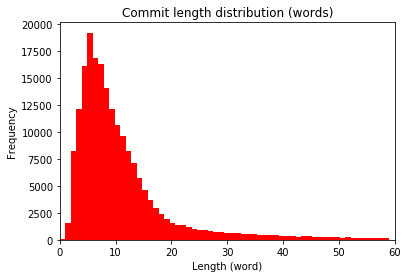

In [44]:
k = 60
data.len_word[data.len_word<k].plot.hist(bins=k, color='red')
plt.xlim((0, k))
plt.xlabel('Length (word)')
plt.title('Commit length distribution (words)');

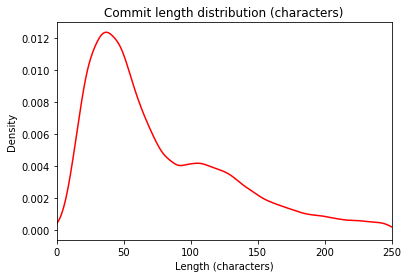

In [45]:
k = 250
data.len_char[data.len_char<k].plot.kde(color='red')
plt.xlim((0, k))
plt.xlabel('Length (characters)')
plt.title('Commit length distribution (characters)');

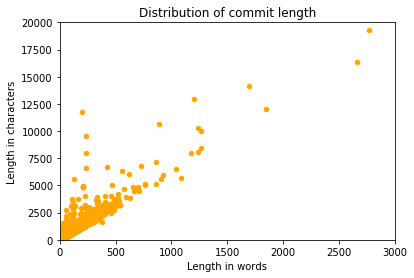

In [50]:
data.plot.scatter('len_word', 'len_char', color='orange')
plt.xlim((0, 3000))
plt.ylim((0, 20000))
plt.title('Distribution of commit length')
plt.xlabel('Length in words')
plt.ylabel('Length in characters');

In [52]:
data.corr()

,len_word,len_char
len_word,1.000000,0.958559
len_char,0.958559,1.000000


In [46]:
from utils import *

UD = Model('./data/english-ewt-ud-2.3-181115.udpipe')

def conllu(text):
        #text = ' '.join(tknzr.tokenize(text))
        sentences = UD.tokenize(text)
        for s in sentences:
            UD.tag(s)
            UD.parse(s)
        conllu = UD.write(sentences, "conllu")
        return conllu

In [10]:
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer()

In [13]:
print(conllu('I like :)) http://web.com'))

# newdoc
# newpar
# sent_id = 1
# text = I like :))
1	I	I	PRON	PRP	Case=Nom|Number=Sing|Person=1|PronType=Prs	2	nsubj	_	_
2	like	like	VERB	VBP	Mood=Ind|Tense=Pres|VerbForm=Fin	0	root	_	_
3	:)	:)	SYM	NFP	_	2	discourse	_	SpaceAfter=No
4	)	)	PUNCT	-RRB-	_	2	punct	_	_

# sent_id = 2
# text = http://web.com
1	http://web.com	http://web.com	X	ADD	_	0	root	_	SpaceAfter=No




In [ ]:
%%time 
apply('C', 'text', 'conllu', conllu, k=1000, start=16682000)
#16682000skl = 

Всё работает, но очень долго

## Статистика (в процессе)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [10]:
def language_stat():
    mycursor.execute('SELECT count(language), language, LEFT(created_at, 4) \
FROM R GROUP BY language, LEFT(created_at, 4) ORDER BY language, LEFT(created_at, 4)')
    df = pd.DataFrame(mycursor.fetchall())
    df.columns = ['n', 'lang', 'year']
    return df

In [11]:
df = language_stat()

In [12]:
df.tail()

,n,lang,year
926,1,Yacc,2015
927,1,YARA,2014
928,1,YARA,2015
929,2,YARA,2016
930,1,YASnippet,2010


In [13]:
df.groupby('lang').sum().sort_values('n', ascending=False).head(10)

,n
lang,
JavaScript,17480
Python,8689
Java,8357
Objective-C,3890
PHP,3540
Go,3496
C++,3449
Ruby,3379
C,3202


In [14]:
import numpy as np

In [15]:
def number_of_repos_by_language(df, data, size=(10, 5,)):
    x = list(range(2007, 2019))
    d = []
    labels = []
    
    for key in data:
        d += [df[df.lang==key].values]
        labels += [data[key]]
    y = np.zeros((len(d), len (x))).tolist()

    for key, i in enumerate(d):
        for j in i:
            y[key][int(j[2])-2007] = j[0]

    plt.figure(figsize=size)
    for key, i in enumerate(y):
        plt.plot(x, i, label=labels[key])
    plt.legend()
    plt.title('Number of repositories')
    plt.xlabel('Year')
    plt.ylabel('Number of repositories');

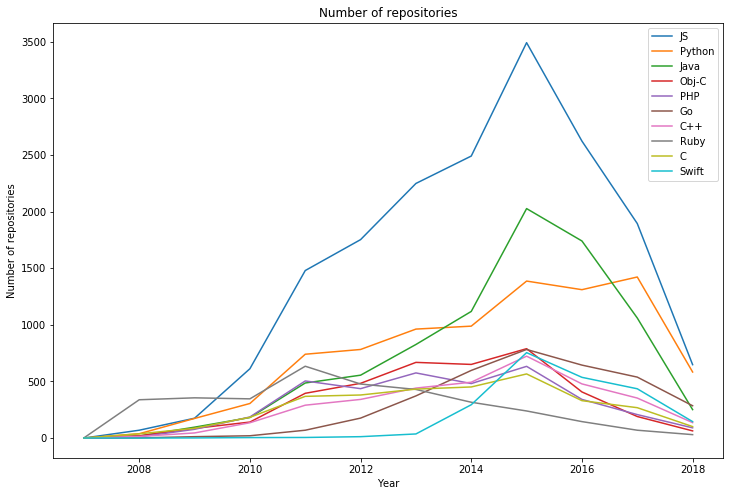

In [16]:
data = {'JavaScript':'JS', 
        'Python':'Python',
        'Java':'Java',
        'Objective-C':'Obj-C',
        'PHP':'PHP',
        'Go':'Go',
        'C++':'C++',
        'Ruby':'Ruby',
        'C':'C',
        'Swift':'Swift'
       }
number_of_repos_by_language(df, data, size=(12, 8,))

In [42]:
def get_repo_commit_timeline(name, owner):
    mycursor.execute('SELECT gh_id FROM R WHERE name = %s AND owner = %s', (name, owner,))
    repo_id = mycursor.fetchone()[0]
    mycursor.execute('SELECT count(id), LEFT(date, 7) FROM C WHERE repo_id = %s \
    GROUP BY LEFT(date, 7) ORDER BY LEFT(date, 7)', (repo_id,))
    df = pd.DataFrame(mycursor.fetchall())
    df.columns = ['n', 'month']
    
    x = list(range(0, skl.shape[0]))
    ticks = skl.month.values
    y = skl.n.values

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, color='green')
    plt.title('Number of commits in {}/{} repository through time'.format(owner, name))
    plt.xlabel('Month')
    plt.ylabel('Number of commits')
    plt.xticks(x[::3], ticks[::3], rotation=90);

CPU times: user 29.2 ms, sys: 0 ns, total: 29.2 ms
Wall time: 124 ms


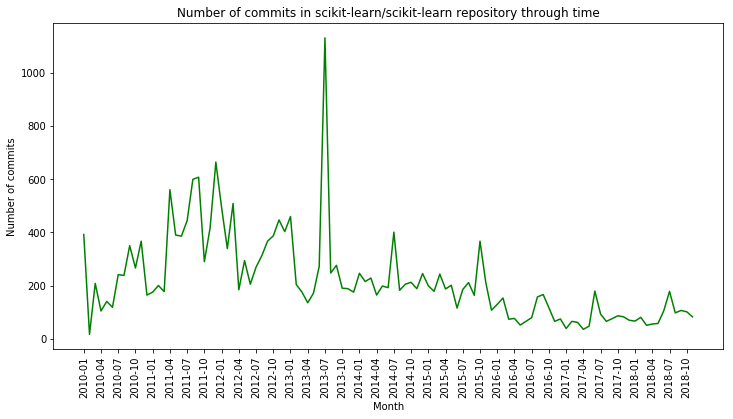

In [43]:
%%time
get_repo_commit_timeline('scikit-learn', 'scikit-learn')

## Обработка информации разметки

In [61]:
MAP = {'token':1, 'lemma':2, 'upos':3, 'xpos':4, 'morpho':5, 'head':6, 'rel':7}

In [52]:
def connlu_parse(conllu, out='gensim', mode='lemma'):
    sentences = [i.split('\n') for i in conllu.strip().split('\n\n')]
    result = []
    for sent in sentences:
        result.append([])
        for token in sent:
            tk = token.split('\t')
            if len(tk) == 10:
                result[-1].append(tk[MAP[mode]])
    if out == 'space':
        pass
    elif out == 'gensim':
        return result

In [55]:
text = conllu('He likes :)) www.twitter.com... And other things')

In [57]:
connlu_parse(text, mode='lemma')

[['he', 'like', ':)', ')', 'www.twitter.com', '...'],
 ['and', 'other', 'thing']]

In [58]:
connlu_parse(text, mode='xpos')

[['PRP', 'VBZ', 'NFP', '-RRB-', 'ADD', '.'], ['CC', 'JJ', 'NNS']]

In [59]:
connlu_parse(text, mode='upos')

[['PRON', 'VERB', 'SYM', 'PUNCT', 'X', 'PUNCT'], ['CCONJ', 'ADJ', 'NOUN']]

In [62]:
connlu_parse(text, mode='rel')

[['nsubj', 'parataxis', 'punct', 'punct', 'root', 'punct'],
 ['cc', 'amod', 'root']]

In [66]:
def get_some_connlu(start, stop, out='gensim', mode='lemma'):
    mycursor.execute('SELECT conllu from C WHERE %s <= id AND id <= %s', (start, stop))
    data = mycursor.fetchall()
    for i in data:
        yield connlu_parse(i[0], out=out, mode=mode)

In [68]:
for i in get_some_connlu(1, 10):
    print (i, end='\n\n')

[['merge', 'pull', 'request', '#', '183', 'from', 'bkeeper', '/', 'unmaintained'], ['clearly', 'state', 'the', 'project', 'status']]

[['clarify', 'status']]

[['fix', 'Tempfile', 'usage', 'under', 'ruby', '1.8.7'], ['there', 'be', 'no', 'third', 'argument', 'to', 'Tempfile#open', 'under', '1.8.7', '.'], ['the', 'default', 'mode', 'be', 'w', '+', 'which', 'should', 'be', 'fine', 'and', 'there', 'be', 'no', 'encoding', 'support', 'so', 'the', 'binary', 'flag', 'do', 'not', 'matter', '.']]

[['merge', 'pull', 'request', '#', '157', 'from', 'github/atomic', '-object-write'], ['Atomic', 'object', 'write']]

[['fsync', 'loose', 'object', 'before', 'move', 'into', 'place'], ['when', 'we', 'write', 'a', 'loose', 'object', 'to', 'disk', ',', 'we', 'simply', 'close', 'the', 'file', 'object', 'before', 'move', 'it', 'into', 'place', '.'], ['if', 'the', 'machine', 'crash', 'shortly', 'after', 'we', 'write', ',', 'the', 'contents', 'may', 'not', 'have', 'be', 'commit', 'to', 'disk', '(', 'depend',

# Параллелизация (пока не получилось)

## <Это первый вариант, не актуально>

In [ ]:
import os
import ipyparallel as ipp

rc = ipp.Client()

In [11]:
os.getpid()

3313

In [12]:
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()

In [14]:
pid_map

{0: 3404, 1: 3406, 2: 3410, 3: 3421, 4: 3430, 5: 3434, 6: 3444}

In [16]:
import numpy as np

In [42]:
def rd():
    import numpy as np
    print (np.random.choice([0,1,2,3,4,5,6]))

In [43]:
%%time 
from multiprocessing import Pool
import tqdm
import time
from IPython.display import clear_output
clear_output()

def _foo(*my_number):
    print (type(my_number))
    square = my_number[0] * my_number[0]
    time.sleep(1)
    #clear_output()
    #print (square)
    #clear_output()
    return square 

if __name__ == '__main__':
    with Pool(2) as p:
        args = [[3,4], (4,5), (5,5), (6,5)]
        #for i in tqdm.tqdm_notebook(p.imap(_foo, range(33)), total=33):
        for i in tqdm.tqdm_notebook(p.starmap(_foo, args), total=len(args)):
            #print (i)
            #clear_output()
            #print (i)
            #clear_output()
            pass

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>



CPU times: user 47.8 ms, sys: 16.3 ms, total: 64.2 ms
Wall time: 2.12 s


In [ ]:
%%time 
from multiprocessing import Pool
import tqdm
import time
from IPython.display import clear_output
clear_output()

def _foo(my_number):
    square = my_number * my_number
    time.sleep(1)
    print (square)
    clear_output()
    return square 

if __name__ == '__main__':
    with Pool(2) as p:
        args = [()]
        for i in tqdm.tqdm(p.imap(_foo, range(30)), total=30):
            #print (i)
            #clear_output()
            print (i)
            #clear_output()

In [27]:
from multiprocessing import Pool
import time
from tqdm import tqdm_notebook as tqdm

def _foo(my_number):
    for i in tqdm(range(0,10)):
        time.sleep(0.5)
        print (my_number)
    #return square 

def f(x):
    return x[0]*x[0]
if __name__ == '__main__':
    with Pool(processes=8) as p:
        #max_ = 30
        ##with tqdm(total=max_) as pbar:
        #for i, _ in tqdm(enumerate(p.imap_unordered(_foo, range(0, max_))), total=max_):
        #    pass
        for _,i in tqdm(enumerate(p.map(f, [tuple([i]) for i in range(10)])), total = 10):
            print(i)
            time.sleep(1)

Process ForkPoolWorker-202:
Process ForkPoolWorker-204:
Process ForkPoolWorker-203:
Process ForkPoolWorker-201:
Process ForkPoolWorker-206:
Process ForkPoolWorker-208:
Process ForkPoolWorker-205:
Process ForkPoolWorker-207:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", 

KeyboardInterrupt: 

In [54]:
import time
import random

In [36]:
from multiprocessing import Pool, TimeoutError
import time
import os

def f():
    #n = os.getpid()
    for i in tqdm(range(0,100)):
        time.sleep(random.randint(0,1))

In [28]:
from tqdm import tqdm_notebook as tqdm
import random

In [ ]:
with Pool(processes=8) as pool:

        ## evaluate "f(20)" asynchronously
        #res = pool.apply_async(f, (20,))      # runs in *only* one process
        #print(res.get(timeout=10000))             # prints "400"

        ## evaluate "os.getpid()" asynchronously
        #res = pool.apply_async(os.getpid, ()) # runs in *only* one process
        #print(res.get(timeout=10000))             # prints the PID of that process

        # launching multiple evaluations asynchronously *may* use more processes
        multiple_results = [pool.apply_async(f, ()) for i in range(4)]
        print([res.get(timeout=10000) for res in multiple_results])

        # make a single worker sleep for 10 secs
        res = pool.apply_async(time.sleep, (10,))
        try:
            print(res.get(timeout=10000))
        except TimeoutError:
            print("We lacked patience and got a multiprocessing.TimeoutError")

        print("For the moment, the pool remains available for more work")

    # exiting the 'with'-block has stopped the pool
print("Now the pool is closed and no longer available")

#

In [1]:
import mysql.connector
from multiprocessing import Pool, TimeoutError
import time
import os
from tqdm import tqdm_notebook as tqdm
from funcs import *
from IPython.display import clear_output
clear_output()
password = 'mandarinka'
UD = Model('./english-ud-2.1-20180111.udpipe')

pbar = None

def conllu(text):
        #text = ' '.join(tknzr.tokenize(text))
        sentences = UD.tokenize(text)
        for s in sentences:
            UD.tag(s)
            UD.parse(s)
        conllu = UD.write(sentences, "conllu")
        return conllu

class ParDB:
    def __init__(self, n_jobs=4):
        self.nrows = {'C': 74352960, 'R': 79422, 'U':630193}
        self.n_jobs = n_jobs
        self.select_con = [mysql.connector.connect(host="localhost",
                                                   user="root",
                                                   passwd=password,
                                                   database="commits_db",
                                                   charset='utf8mb4') for i in range(n_jobs)]
        self.select_cur = [i.cursor() for i in self.select_con]
        self.update_con = [mysql.connector.connect(host="localhost",
                                                   user="root",
                                                   passwd=password,
                                                   database="commits_db",
                                                   charset='utf8mb4') for i in range(n_jobs)]
        self.update_cur = [i.cursor() for i in self.update_con]
        
    def _one(self, start, job):
        #start = arg[0]
        #job = arg[1]
        global pbar
        request = 'SELECT id, {} FROM {} WHERE id >= {} LIMIT {}'.format(self.source, 
                                                                        self.table, 
                                                                        start, 
                                                                        self.k)
        self.select_cur[job].execute(request)
        data = self.select_cur[job].fetchall()
        result = []
        for i in data:
            print (i)
            result.append(tuple([self.function(i[1]), i[0]]))
        self.update_cur[job].executemany(self.update, result)
        self.update_con[job].commit()
        return job
        #print ('{}/{}'.format(start, self.nrows[self.table]))
        #clear_output()
    
    def _yield_args(self):
        for key, i in enumerate(range(self.start, self.nrows[self.table], self.k)):
            yield (i, key % self.n_jobs)

    def apply(self, table, source, target, function, k=10000, start=0, shared_model=None):
        global pbar
        self.table = table
        self.source = source
        self.target = target
        self.function = function
        self.k = k
        self.start = start
        self.update = 'UPDATE {} SET {}=%s WHERE id=%s'.format(table, target) 
        self.max_ = self.nrows[table] - start
        
        #pbar = tqdm(total=max_)
        #args = list(self._yield_args())
        #p = Pool(self.n_jobs)
        #for i in tqdm(range(0, max_, self.k)):
        #    #try:
        #        A = args[i:i+self.k]
        #        #print (i, A)
        #        print(p.starmap(self._one, A))
        #    #except:
        #    #    print(args[i])
        #    #    break
        #p.close()
        ##pbar.close()
        #print ('This is the end...')

In [2]:
DB = ParDB(n_jobs = 8)

In [3]:
DB.apply('C', 'text', 'len_char', len, k=100, start=0)

In [ ]:
        args = list(DB._yield_args())
        p = Pool(DB.n_jobs)
        for i in tqdm(range(0, DB.max_, DB.k)):
            #try:
                A = args[i:i+DB.k]
                #print (i, A)
                print(p.starmap(DB._one, A))
            #except:
            #    print(args[i])
            #    break
        p.close()
        #pbar.close()
        print ('This is the end...')

In [ ]:
DB.apply('C', 'text', 'conllu', conllu, k=1000, start=16682000)

In [1]:
import mysql.connector
from multiprocessing import Pool, TimeoutError
import time
import os
from tqdm import tqdm_notebook as tqdm
from funcs import *

#UD = Model('./english-ud-2.1-20180111.udpipe')

def conllu(text):
        return text

class ParDB:
    def __init__(self):
        pass
        
    def _one(self, start, job):
        #global pbar
        time.sleep(1)
        #print (job, start)
        return 1
    
    def _yield_args(self):
        for i in range(0,1000):
            yield (i, i % 8)

    def apply(self):
        #global pbar
        max_ = 100000
        pbar = tqdm(total=max_)
        args = list(self._yield_args())
        p = Pool(8)
        p.starmap(self._one, args)
        pool.close()
        pbar.close()
        print ('This is the end...')

In [2]:
DB = ParDB()

In [ ]:
DB.apply()

In [1]:
def conllu(text):
        #text = ' '.join(tknzr.tokenize(text))
        sentences = UD.tokenize(text)
        for s in sentences:
            UD.tag(s)
            UD.parse(s)
        conllu = UD.write(sentences, "conllu")
        return conllu

class ParDB:
    def __init__(self, n_jobs=4):
        self.nrows = {'C': 74352960, 'R': 79422, 'U':630193}
        self.n_jobs = n_jobs
        self.select_con = [mysql.connector.connect(host="localhost",
                                                   user="root",
                                                   passwd=password,
                                                   database="commits_db",
                                                   charset='utf8mb4') for i in range(n_jobs)]
        self.select_cur = [i.cursor() for i in self.select_con]
        self.update_con = [mysql.connector.connect(host="localhost",
                                                   user="root",
                                                   passwd=password,
                                                   database="commits_db",
                                                   charset='utf8mb4') for i in range(n_jobs)]
        self.update_cur = [i.cursor() for i in self.update_con]
    def _yield_args(self):
        for key, i in enumerate(range(self.start, self.nrows[self.table], self.k)):
            yield [i, key % self.n_jobs]
        
def _one(self, start, job):
        #start = arg[0]
        #job = arg[1]
        global pbar
        request = 'SELECT id, {} FROM {} WHERE id >= {} LIMIT {}'.format(self.source, 
                                                                        self.table, 
                                                                        start, 
                                                                        self.k)
        self.select_cur[job].execute(request)
        data = self.select_cur[job].fetchall()
        result = []
        for i in data:
            print (i)
            result.append(tuple([self.function(i[1]), i[0]]))
        self.update_cur[job].executemany(self.update, result)
        self.update_con[job].commit()
        return job
        #print ('{}/{}'.format(start, self.nrows[self.table]))
        #clear_output()
    

def apply(self, table, source, target, function, k=10000, start=0, shared_model=None):
        self.table = table
        self.source = source
        self.target = target
        self.function = function
        self.k = k
        self.start = start
        self.update = 'UPDATE {} SET {}=%s WHERE id=%s'.format(table, target) 
        self.max_ = self.nrows[table] - start
        
        pbar = tqdm(total=self.max_)
        args = list(self._yield_args())
        p = Pool(self.n_jobs)
        for i in tqdm(range(0, self.max_, self.k)):
            #try:
                A = args[i:i+self.k]
                B = [[self]+j for j in A]
                #print (i, A)
                print(p.starmap(_one, B))
            #except:
            #    print(args[i])
            #    break
        p.close()
        #pbar.close()
        print ('This is the end...')

In [2]:
DB = ParDB(n_jobs = 8)

In [ ]:
apply(DB, 'C', 'text', 'len_char', len, k=100, start=0)

In [2]:
from ipyparallel import Client
rc = Client()
rc.block = True
dview = rc.load_balanced_view()

In [3]:
%%px

import mysql.connector
password='password'
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="commits_db",
  charset='utf8mb4')

mycursor = mydb.cursor()

mydb2 = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="commits_db",
  charset='utf8mb4')

updatecursor = mydb2.cursor()

In [4]:
%%px

def _one(table, source, target, function, start, chunk=1000):
    request = 'SELECT id, {} FROM {} WHERE id >= {} LIMIT {}'.format(source, table, start, chunk)
    update = 'UPDATE {} SET {}=%s WHERE id=%s'.format(table, target) 
    mycursor.execute(request)
    data = mycursor.fetchall()
    result = []
    for i in data:
        result.append(tuple([function(i[1]), i[0]]))
    updatecursor.executemany(update, result)
    mydb2.commit()
    return 1

In [5]:
def _one(table, source, target, function, start, chunk=1000):
    request = 'SELECT id, {} FROM {} WHERE id >= {} LIMIT {}'.format(source, table, start, chunk)
    update = 'UPDATE {} SET {}=%s WHERE id=%s'.format(table, target) 
    mycursor.execute(request)
    data = mycursor.fetchall()
    result = []
    for i in data:
        result.append(tuple([function(i[1]), i[0]]))
    updatecursor.executemany(update, result)
    mydb2.commit()
    return 1

In [6]:
from tqdm import tqdm_notebook as tqdm
nrows = {'C': 74352960, 'R': 79422, 'U':630193}

In [8]:
apply(dview, 'C', 'text', 'char_len', len, 0, n_jobs=8, chunk=1000, group=100)

In [7]:
%%px
import sys
sys.path.append('/home/glznv/GitHub/Git_Commits')
from utils import *

UD = Model('/home/glznv/GitHub/Git_Commits/data/english-ewt-ud-2.3-181115.udpipe')

def conllu(text):
        #text = ' '.join(tknzr.tokenize(text))
        sentences = UD.tokenize(text)
        for s in sentences:
            UD.tag(s)
            UD.parse(s)
        conllu = UD.write(sentences, "conllu")
        return conllu

In [8]:
import sys
sys.path.append('/home/glznv/GitHub/Git_Commits')
from utils import *

UD = Model('/home/glznv/GitHub/Git_Commits/data/english-ewt-ud-2.3-181115.udpipe')
def conllu(text):
        #text = ' '.join(tknzr.tokenize(text))
        sentences = UD.tokenize(text)
        for s in sentences:
            UD.tag(s)
            UD.parse(s)
        conllu = UD.write(sentences, "conllu")
        return conllu

In [9]:
import time

In [10]:
import math
def apply(dview, table, source, target, function, start, n_jobs=8, chunk=1000, group=None):
    def _yield_args():
        for i in range(start, nrows[table], chunk):
            yield i
    if group is None:
        group = n_jobs
    args = _yield_args()
    pbar = tqdm(total = nrows[table])
    pbar.update(start)
    n_iter = int(math.ceil((nrows[table] - start)/chunk/float(group)))
    for i in range(n_iter):
        starts = []
        for _ in range(group):
            try:
                starts.append(next(args))
            except StopIteration:
                pass
        k = len(starts)
        results = dview.map(_one, [table]*k, [source]*k, [target]*k, [function]*k, starts, [chunk]*k) 
        #results = [1]*group
        pbar.update(len(results)*chunk)
        time.sleep(1)

In [11]:
apply(dview, 'C', 'text', 'conllu', conllu, 24000000, n_jobs=8, chunk=1000, group=100)

## Small DB

In [1]:
password = 'password'

In [2]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="small_commits_db",
  charset='utf8mb4')

mycursor = mydb.cursor()

import codecs
codecs.register(lambda name: codecs.lookup('utf8') if name == 'utf8mb4' else None)

con = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd=password,
  database="commits_db",
  charset='utf8mb4')

cur = con.cursor()

In [4]:
cur.execute('SELECT * FROM U')
data = cur.fetchall()
mycursor.executemany('INSERT INTO U \
(id, gh_id, login, location, pub_repos, followers, private_repos,following, created_at) \
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)', data)

In [4]:
mydb.rollback()

In [5]:
mydb.commit()

In [6]:
cur.execute('SELECT * FROM R')
data = cur.fetchall()

In [7]:
mycursor.executemany('INSERT INTO R \
(id, gh_id, owner, name, language, ncommits, created_at,\
updated_at, size, stars, subs, watchers, network_count, has_wiki,\
languages_url) \
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)', data)

In [8]:
mydb.commit()

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
cur.execute('SELECT * FROM C LIMIT 2000000')

In [5]:
for i in tqdm(range(2000)):
    data = cur.fetchmany(1000)
    mycursor.executemany('INSERT INTO C \
    (id, user, repo_id, text, date, char_len, word_len, conllu) \
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s)', data)
    mydb.commit()